# pix2pix: Image-to-image translation with a conditional GAN

#### Import

In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

#### Load the dataset

In [2]:
URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname="facades.tar.gz",
    origin=URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/"facades"

30179328/30168306 [==============================] - 12s 0us/step


→ Pix2Pix 학습에 사용할 이미지 다운로드(프라하 체코 공과대학의 데이터)

In [3]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades.tar.gz'),
 PosixPath('/root/.keras/datasets/facades')]

In [4]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
# 위에서 다운 받은 데이터 경로에서 파일 읽어오기
sample_image = tf.io.decode_jpeg(sample_image)
# 한장을 이미지로 읽기
print(sample_image.shape)

(256, 512, 3)


→ 256x512 3-channel image인 것을 확인

* 시각화

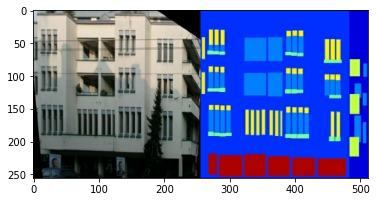

In [5]:
plt.figure()
plt.imshow(sample_image)

→ 256x256 2장임을 확인(한장은 일반 이미지, 한장은 map 이미지)

* image를 input으로 입력받아서 실제 이미지와 map 이미지를 분할하는 함수

In [6]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)
  # 이미지 읽어오기

  w = tf.shape(image)[1]
  # 이미지의 가로길이를 가져오고
  w = w // 2
  # 절반으로 나눈 다음
  input_image = image[:, w:, :]
  # 뒷 부분은 input 이미지
  real_image = image[:, :w, :]
  # 앞부분은 real 이미지

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  # 둘다 float32 tensor 형식으로 변형

  return input_image, real_image

* 함수에 이미지 입력

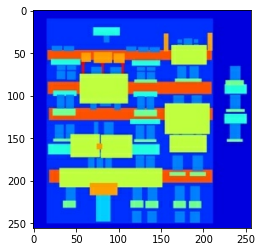

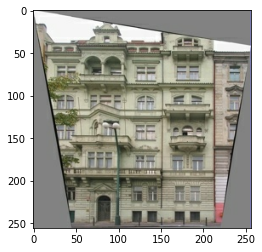

In [7]:
inp, re = load(str(PATH / 'train/100.jpg'))
# 위에서 구햔한 함수에 image 한장 출력
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

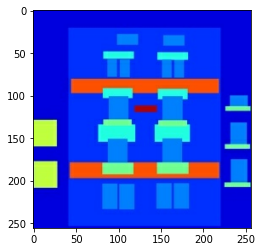

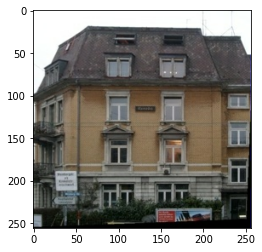

In [8]:
inp, re = load(str(PATH / 'train/200.jpg'))
# 위에서 구햔한 함수에 image 한장 출력
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [9]:
BUFFER_SIZE = 400
# 이미지 갯수
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
# 조정할 이미지 사이즈

* 이미지 사이즈 조정 함수

In [10]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # 이미지를 주변의 유사한 픽셀 값으로 조정
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # 이미지를 주변의 유사한 픽셀 값으로 조정
  return input_image, real_image

* 랜덤으로 자르는 함수

In [11]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  # 이미지를 입력받아서 쌓고
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  # 랜덤하게 자르고 출력
  return cropped_image[0], cropped_image[1]
  # image augmentation의 효과

In [12]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  # 이미지 정규화(-1~+1)
  return input_image, real_image

* Random Jitter 함수 : 이미지를 입력 받으면 286x286 사이즈로 조정하고 이 크기 안에서 다시 Random하게 256x256으로 Crop

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)
  # 286x286으로 사이즈 조정
  input_image, real_image = random_crop(input_image, real_image)
  # 랜덤하게 다시 256x256으로 crop

  if tf.random.uniform(()) > 0.5:
    # 랜덤하게 가로로 뒤집기
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

* 위에서 시각화한 100번 image를 random jitter 적용

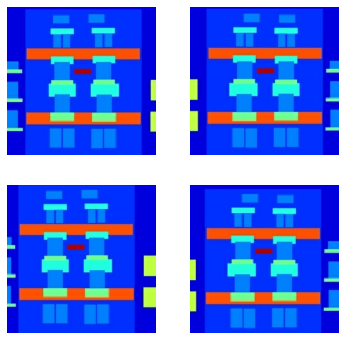

In [14]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

* image load → random jitter → normalize

In [15]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [16]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

* 학습용 데이터 셋

In [17]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
# *** jpg 파일 전체 불러오기
# Dataset 불러오기
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
# map 함수를 병렬적으로 처리

# Dataset에 위에서 정의한 함수 적용

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# Burfer의 갯수만큼 꺼내서 셔플링한다
train_dataset = train_dataset.batch(BATCH_SIZE)
# Batch로 만들기

* 테스트 데이터 셋

In [18]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Model

* encoder

In [19]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  # 초기화
  result = tf.keras.Sequential()
  # sequential
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  # Conv

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
    # BN 여부

  result.add(tf.keras.layers.LeakyReLU())
  # LeakyReLU

  return result

In [21]:
down_model = downsample(3, 4)
# filter 3개, kernel szie = 4

In [22]:
down_result = down_model(tf.expand_dims(inp, 0))
# 위의 이미지 입력
print (down_result.shape)

(1, 128, 128, 3)


→ feature map size가 절반 줄었고 3개의 channel로 출력

* decoder

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  # 초기화
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  # Conv2DTranspose
  
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


→ 원본으로 회복

In [26]:
from PIL import Image

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


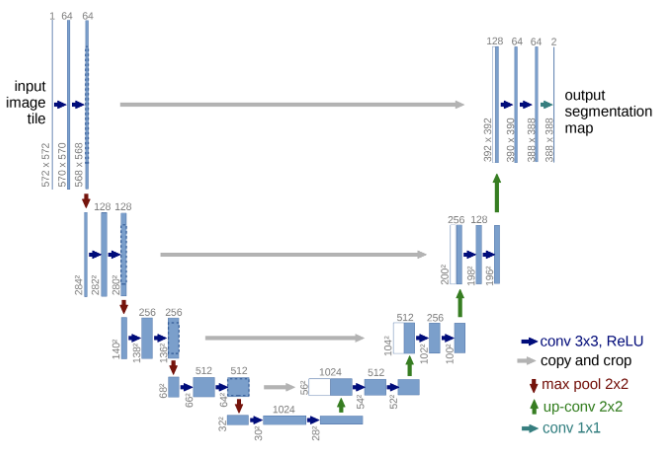

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/Unet1.png')

* Generator

In [28]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  
    # (batch_size, 128, 128, 64)
    downsample(128, 4),  
    # (batch_size, 64, 64, 128)
    downsample(256, 4),  
    # (batch_size, 32, 32, 256)
    downsample(512, 4),  
    # (batch_size, 16, 16, 512)
    downsample(512, 4),  
    # (batch_size, 8, 8, 512)
    downsample(512, 4),  
    # (batch_size, 4, 4, 512)
    downsample(512, 4),  
    # (batch_size, 2, 2, 512)
    downsample(512, 4),  
    # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  
    # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  
    # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  
    # (batch_size, 8, 8, 1024)
    upsample(512, 4),  
    # (batch_size, 16, 16, 1024)
    upsample(256, 4),  
    # (batch_size, 32, 32, 512)
    upsample(128, 4),  
    # (batch_size, 64, 64, 256)
    upsample(64, 4),  
    # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  # 초기화
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  
  # last conv

  # (batch_size, 256, 256, 3)
  # 원본 크기

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    # down_stack의 한번의 step에서
    x = down(x)
    # x는 layer를 통과하는데,
    skips.append(x)
    # 그 값을 skips에 저장
  skips = reversed(skips[:-1])
  # 맨 마지막 값을 제외하고 순서를 거꾸로 하기.

  for up, skip in zip(up_stack, skips):
    # up과 skip의 값을 하나씩 가져오면서
    x = up(x)
    # x를 up layer를 통과시키면서
    x = tf.keras.layers.Concatenate()([x, skip])
    # skip의 값과 더한다

  x = last(x)
  # 그리고 마지막 층 통과

  return tf.keras.Model(inputs=inputs, outputs=x)
  # 위의 순서대로 모델 정의

* Model 시각화

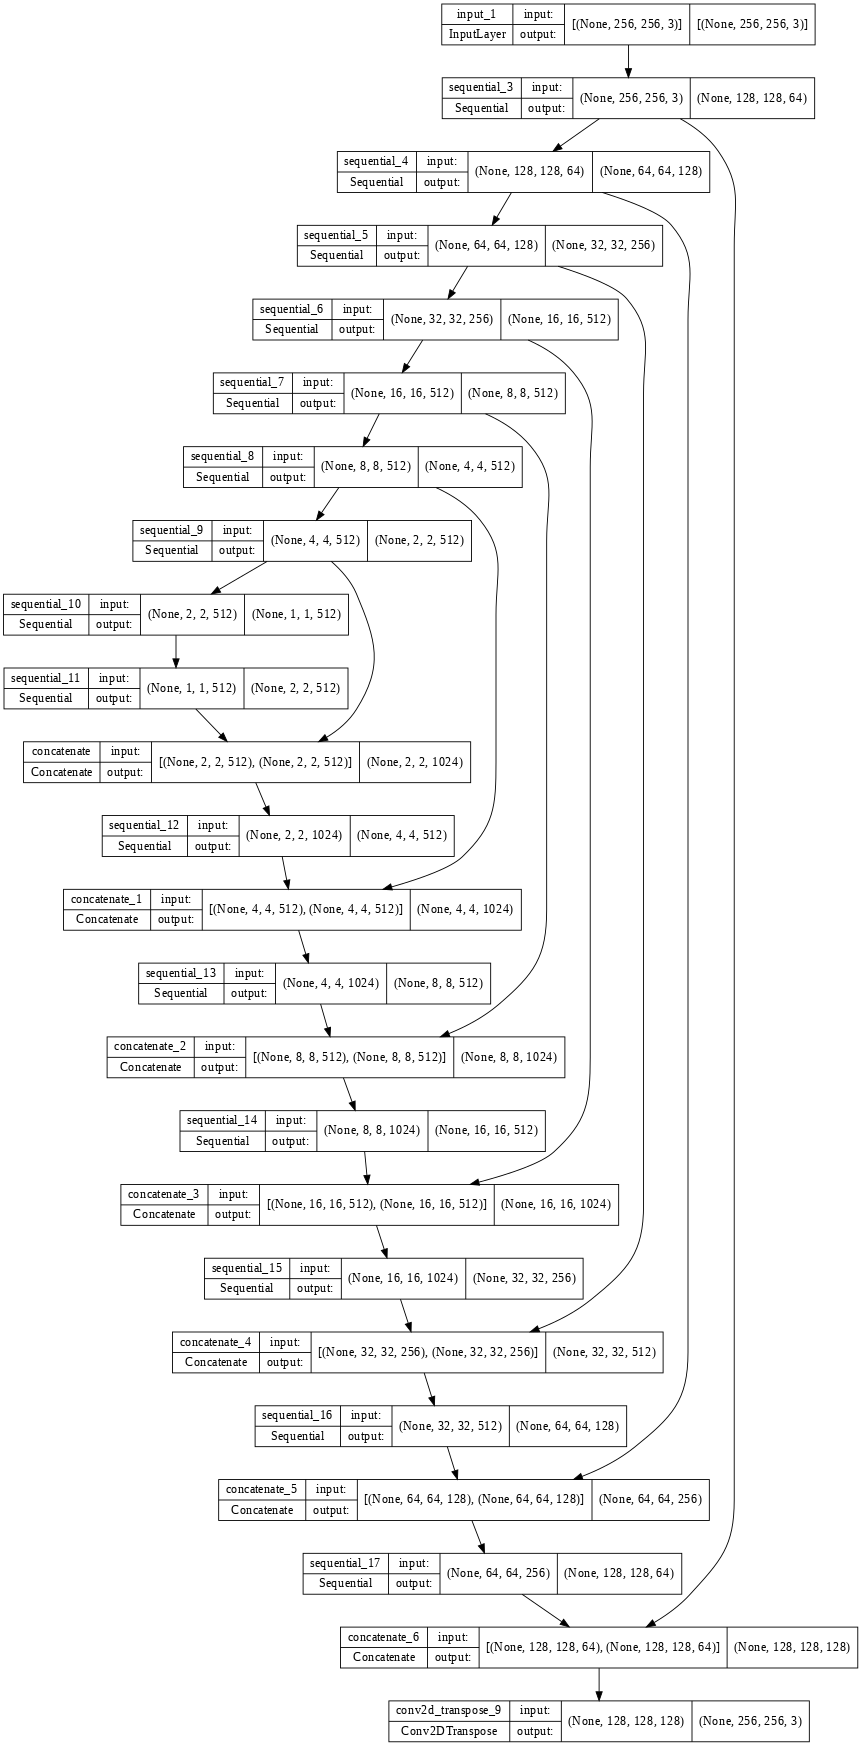

In [29]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# sequential()로 구성한 모델을 시각화 할 수 있음. 모델, shape 정보, 사이즈(인치)

* image 한장 Test

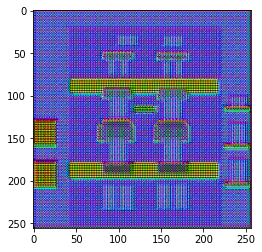

In [30]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
# 한장의 이미지에 차원 추가해서
plt.imshow(gen_output[0, ...])
# 모델에 넣어서 시각화

* Generator Loss : GAN_Loss + LAMBDA * L1_Loss

In [31]:
LAMBDA = 100

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # 생성한 이미지가 real(=1)이라고 속이는 Loss
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  # 생성한 이미지와 실제 이미지의 픽셀간 L1 Loss
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  # total loss
  return total_gen_loss, gan_loss, l1_loss

* Loss를 학습하는 과정

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


* discriminator


In [34]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  # input image(조건부 이미지)
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  # target image(실제 이미지)
  x = tf.keras.layers.concatenate([inp, tar])  
  # (batch_size, 256, 256, channels*2)
  # 두개를 쌓는다
  down1 = downsample(64, 4, False)(x)  
  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  
  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  
  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  
  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  
                                # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  
  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  
                                # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

* Model 시각화

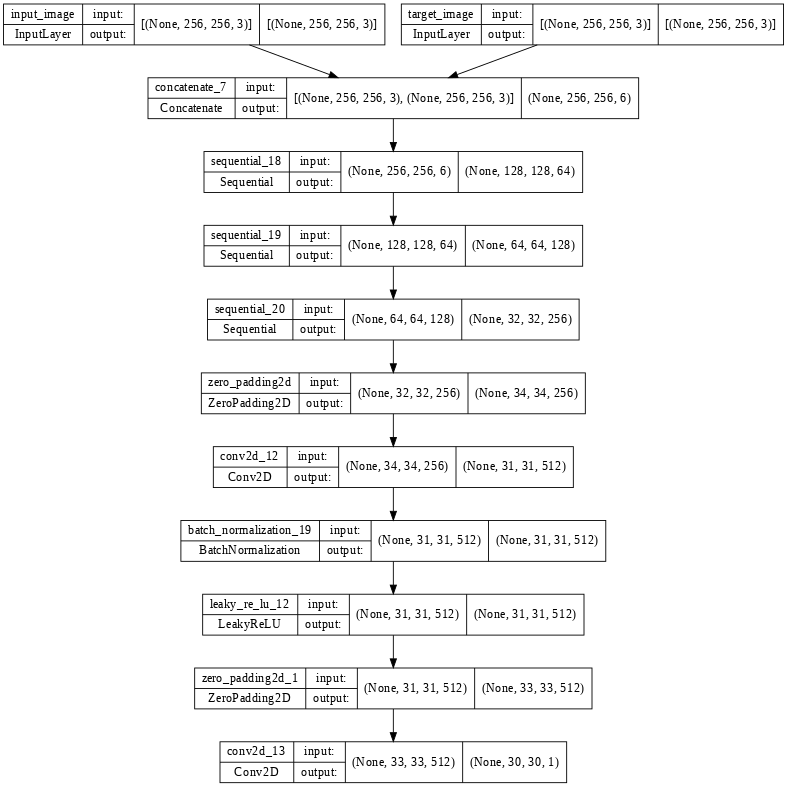

In [35]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

* Image 한장 Test

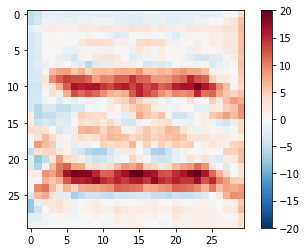

In [36]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

* discriminator loss

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  # 실제 이미지를 1로 구분하도록
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  # 가짜 이미지를 0으로 구분하도록
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

* Loss 학습 과정

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


* Optimizer, Model Check Point

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# check point 사용하면서 모델 학습되도록 정의

* 훈련하면서 이미지 생성하는 함수

In [40]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  # 모델에 테스트 이미지 입력
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  # 각각의 이미지를 list안에 넣고

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    # 각각 시각화 : 픽셀 값 0~1로 변환
    plt.axis('off')
  plt.show()

* 테스트

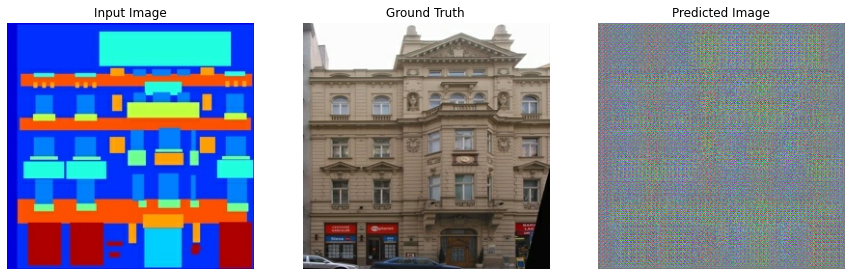

In [41]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

→ 학습이 안되었기에 예측 이미지가 엉터리임.

### Training

In [42]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    # generator에 이미지를 입력
    disc_real_output = discriminator([input_image, target], training=True)
    # discriminator에 진짜 이미지 입력
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    # discriminator에 가짜 이미지 입력
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    # 위에서 정의한 Gen Loss
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    # 위에서 정의한 Dis Loss
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  # loss에 대한 gradient 계산
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  # 동일
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  # optimizer 적용하여 학습

In [43]:
def fit(train_ds, test_ds, epochs):
  for epoch in range(epochs):
    start = time.time()
    # 시작 시간
    display.clear_output(wait=True)
    # epoch 표시 내용 지움 : 시각화로 진행과정 보기 위해
    # 한번의 epoch 학습 후 
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)
    # test

    for n, (input_image, target) in train_ds.enumerate():
      # 데이터 가져오기
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
      # 훈련
    print()


   # if (epoch + 1) % 20 == 0:
   #   checkpoint.save(file_prefix = checkpoint_prefix)
      # 중간 저장

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)
  # 저장

* Train

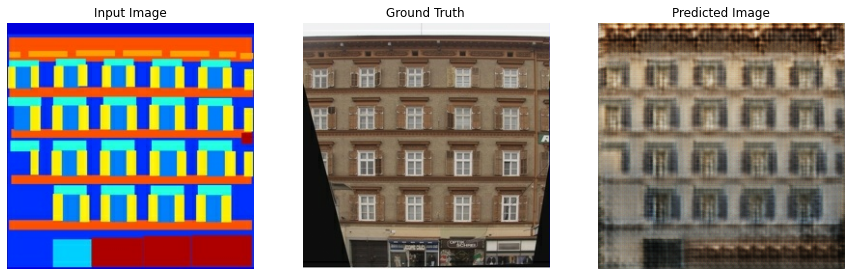

Epoch:  14
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 15 is 23.26670241355896 sec



In [44]:
fit(train_dataset, test_dataset, epochs=15)

* 위까지 학습한 단계에서의 가중치

In [45]:
checkpoint_dir

'./training_checkpoints'

In [46]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

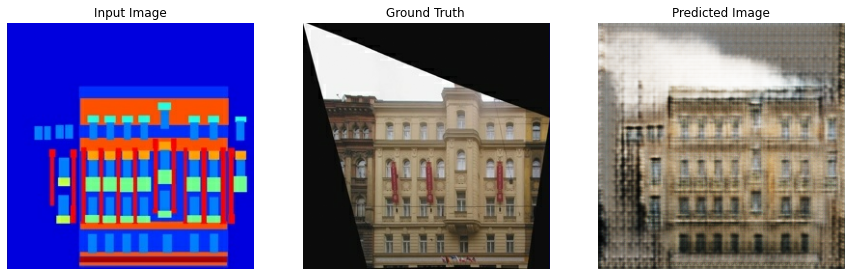

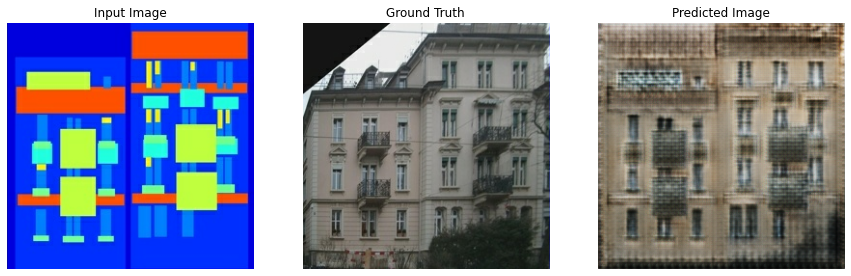

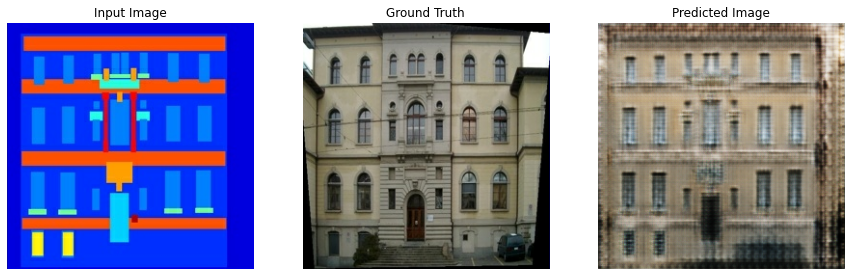

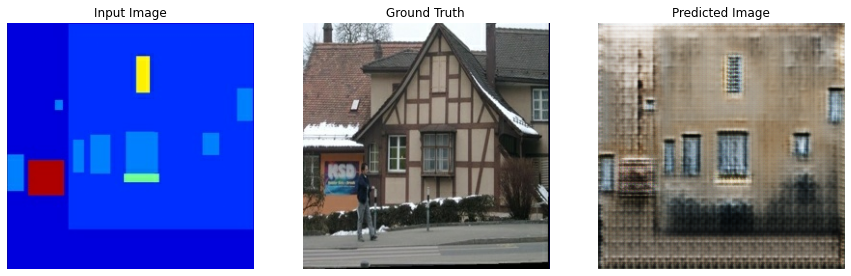

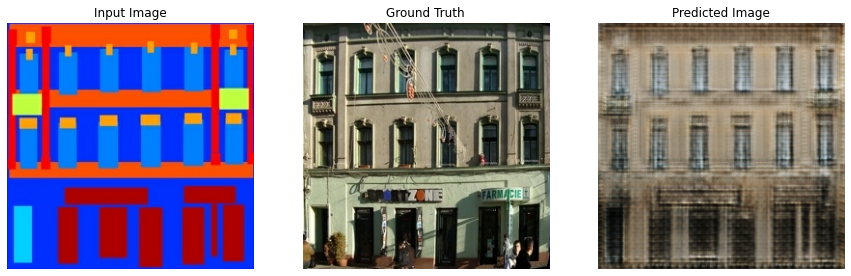

In [47]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

* 사전에 300-epoch로 학습한 가중치

In [48]:
save_dir = '/content/drive/MyDrive/CDS2(2022-2)/pix2pix_weight'

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(save_dir))

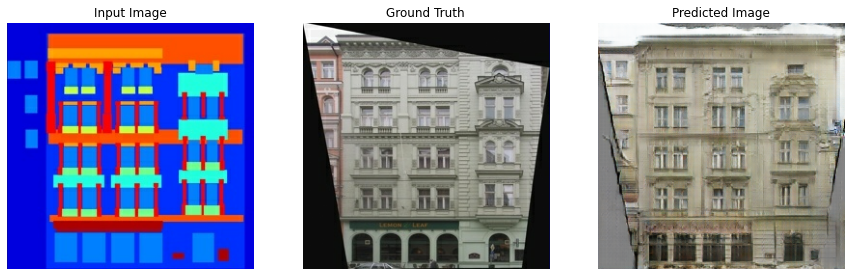

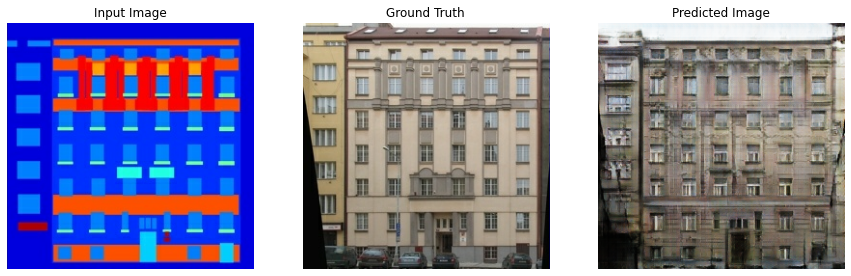

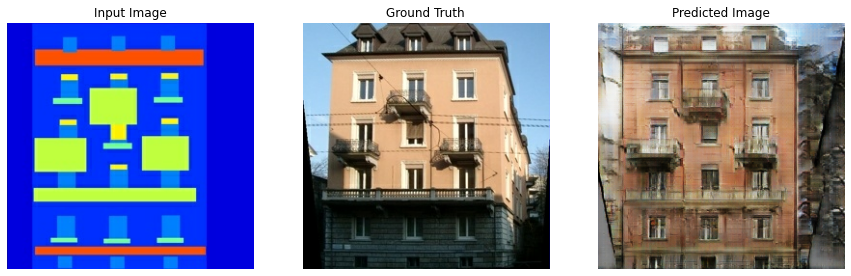

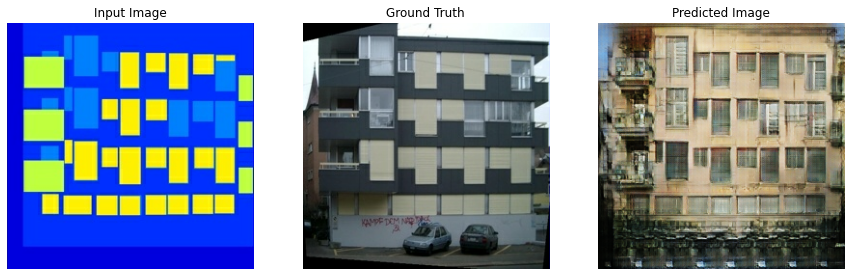

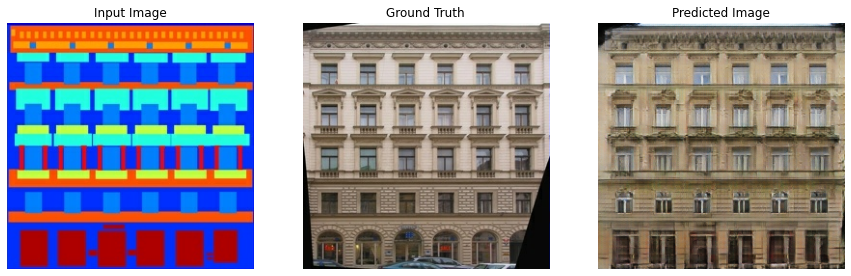

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)